### 온열질환자 구간에 따른 Classification 모델 생성
- 3-dimensional

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
import os
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectPercentile
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from itertools import cycle

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

from imblearn.under_sampling import RandomUnderSampler

In [3]:
# 나눔 폰트 경로 설정
# dir = '/data1/E382/hwchoi/00.data/00.preprocessing'
dir='C:/Windows/Fonts'
font_path = os.path.join(dir, 'NANUMGOTHIC.TTF')
# font_path = os.path.join(dir, 'DejaVu Sans')

# 폰트 속성 설정
fontprop = fm.FontProperties(fname=font_path, size=10)


# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)

# Matplotlib 폰트 캐시 파일 삭제 (필요시 사용)
cache_dir = os.path.expanduser('~/.cache/matplotlib')
font_cache_path = os.path.join(cache_dir, 'fontlist-v330.json')
if os.path.exists(font_cache_path):
    os.remove(font_cache_path)

# 폰트를 matplotlib에 설정
plt.rc('font', family=fontprop.get_name())

###  MODELING

### DecisionTree, RandomForest, XGBoost 데이터 셋 재정리

In [4]:
path='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_0812.csv'
df=pd.read_csv(path)
df.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,...,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,jenks_cluster,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,0.0,0.0,9.6,24.2,...,21,24,22,14,21,17,0,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,0.0,0.0,10.5,23.7,...,21,23,22,15,22,18,0,0,2024-07-31,2024-07-31


In [ ]:
### 0/1 유무

In [5]:
df.groupby('jenks_cluster').size()

jenks_cluster
0    19974
1     5538
2      498
dtype: int64

In [6]:
# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

In [7]:
features=['weekend_yn', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm', 'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man', 'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
# features=['max_ta', 'mean_ta', 'max_tafeel', 'ta_max_am', 'ta_max_pm', 'ta_mean_pm', 'ta_max_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1','ta_mean_six_pm1']
target='jenks_cluster'
print(len(features))

48


In [8]:
X=df[features]
y=df[target]
# 언더샘플링 적용
undersample = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X, y)

In [9]:
# 기본 모델(RandomForest, XGBoost)
# 학습 데이터와 테스트 데이터로 분할
# 데이터 스케일링
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=11, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=11, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
print(y_train.value_counts())
print(y_test.value_counts())

jenks_cluster
0    15984
1     4431
2      393
Name: count, dtype: int64
jenks_cluster
0    3990
1    1107
2     105
Name: count, dtype: int64


In [12]:
def plot_confusion_matrix(conf_matrix, model_name, accuracy):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix\nAccuracy: {accuracy:.2f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [13]:
performance_list = []
num_classes = 3


def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    confusion = confusion_matrix(y_test, y_pred)
    
    for cls in range(num_classes):
        cls = str(cls)
        performance_list.append({
            'Model': model_name,
            'Class': cls,
            'Accuracy': accuracy,
            'Precision': report[cls]['precision'],
            'Recall': report[cls]['recall'],
            'F1-Score': report[cls]['f1-score'],
            'Support': report[cls]['support']
        })
    
    plot_confusion_matrix(confusion, model_name, accuracy)

In [14]:
# Decision Tree 
# dt_classifier = DecisionTreeClassifier(random_state=11)
# evaluate_model(dt_classifier, 'Decision Tree')

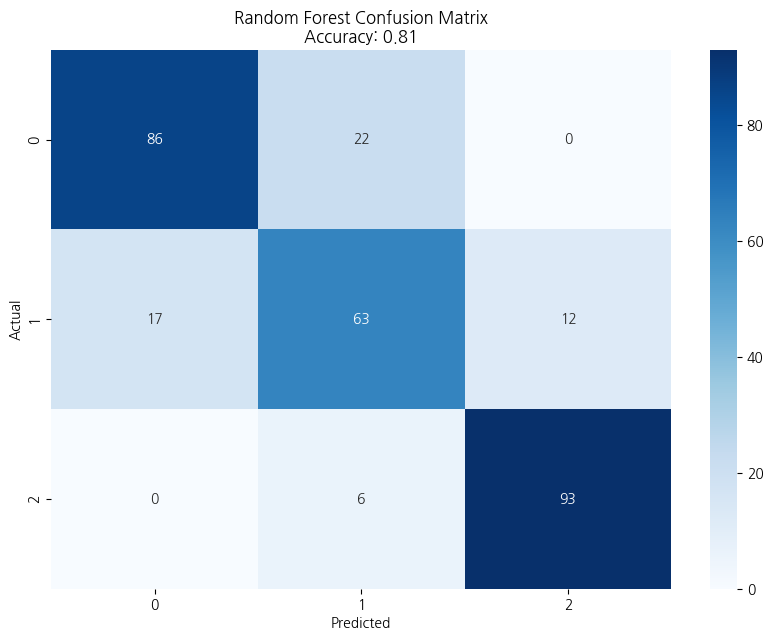

In [15]:
# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=60, random_state=11)
evaluate_model(rf_classifier, 'Random Forest')

In [16]:
# SVM
# svm_classifier = SVC(kernel='linear', random_state=11)
# evaluate_model(svm_classifier, 'SVM')

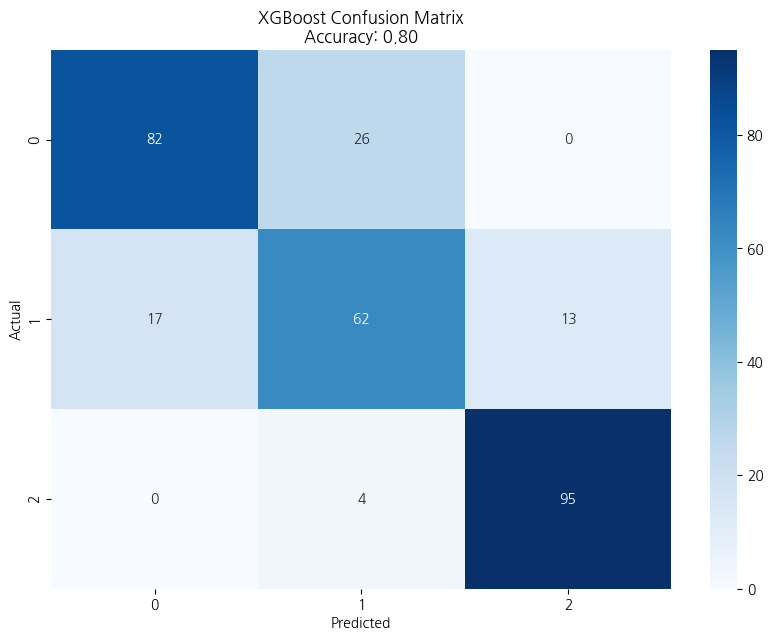

In [17]:
# XGBoost
xgb_classifier = XGBClassifier(eval_metric='logloss', random_state=11)
evaluate_model(xgb_classifier, 'XGBoost')

In [18]:
# 성능 데이터프레임 생성
performance_df = pd.DataFrame(performance_list)
print(performance_df)

           Model Class  Accuracy  Precision    Recall  F1-Score  Support
0  Random Forest     0  0.809365   0.834951  0.796296  0.815166    108.0
1  Random Forest     1  0.809365   0.692308  0.684783  0.688525     92.0
2  Random Forest     2  0.809365   0.885714  0.939394  0.911765     99.0
3        XGBoost     0  0.799331   0.828283  0.759259  0.792271    108.0
4        XGBoost     1  0.799331   0.673913  0.673913  0.673913     92.0
5        XGBoost     2  0.799331   0.879630  0.959596  0.917874     99.0


In [16]:
# performance_df.to_csv('D:/Work/001.project/003.kdca/004.실험/performance_jenkins_v03.csv', index=False, encoding='utf-8-sig')

### Mutual information

In [9]:
# 멀티 분류 문제에서 상호 정보량 계산
X=df[features]
y=df[target]
# 회귀 문제에서 상호 정보량 계산

# Mutual Information 계산
mi_scores = mutual_info_classif(X, y)

# SelectPercentile을 사용하여 상위 20%의 피처 선택
selector = SelectPercentile(mutual_info_classif, percentile=20)
X_selected = selector.fit_transform(X, y)

# 선택된 피처의 이름 가져오기
selected_features = X.columns[selector.get_support()]

# 선택된 피처와 점수 출력
print("Selected Features:", selected_features)
print("Mutual Information Scores:", mi_scores[selector.get_support()])

Selected Features: Index(['max_ta', 'mean_ta', 'max_tafeel', 'ta_max_am', 'ta_max_pm',
       'ta_mean_pm', 'ta_max_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1',
       'ta_mean_six_pm1'],
      dtype='object')
Mutual Information Scores: [0.20630383 0.20564395 0.21705075 0.20703047 0.204475   0.21438463
 0.20820337 0.20436336 0.20574171 0.21115128]
